# Hydrology example from the Vistula catchment in Poland

The Vistula catchment is the largest catchment in Poland, with an area of 194,424 km2. This notebook shows how a hydrolgoical model can evaluated using ModelSkill.  

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import modelskill as ms

In [3]:
fldr = Path("../tests/testdata/Vistula")
df = pd.read_csv(fldr / "stations.csv", index_col=0)
df

,Station,Long,Lat,Area
Id,,,,
6458010,VISTULA (TCZEW),18.80556,54.08722,193922.9
6458500,VISTULA (WARSAW (WARSZAWA)),21.03250,52.24750,84945.1
6458753,PILICA (PRZEDBORZ),19.87528,51.08944,2550.1
6458715,WIEPRZ (LUBARTOW),22.64361,51.49806,6389.8
6458713,WIEPRZ (KRASNYSTAW),23.17667,50.98528,3010.2
6458520,KAMIENNA (KUNOW),21.27889,50.96194,1110.4
6458460,VISTULA (SANDOMIERZ),21.74611,50.67250,31809.9
6458450,VISTULA (SZCZUCIN),21.07722,50.32694,23869.3
6458406,DUNAJEC (NOWY SACZ),20.68722,49.62722,4337.4


In [4]:
def get_comparer(df, mods, id):
    """Get a Comparer object for a given model and station id"""
    q = ms.Quantity(name="Discharge", unit="m3/s")

    # create Observation object
    fp = fldr / mods[0] / f"{id}.csv"
    dfd = pd.read_csv(fp, index_col=0, parse_dates=True)
    o = ms.PointObservation(dfd, item="Qobs", name=df.loc[id].Station,
                            x=df.loc[id].Long, y=df.loc[id].Lat, quantity=q)
    
    # create ModelResult objects
    mm = []
    for m in mods:
        fp = fldr / m / f"{id}.csv"
        dfd = pd.read_csv(fp, index_col=0, parse_dates=True)
        mm.append(ms.PointModelResult(dfd, item="Qsim", name=m, quantity=q))
    
    return ms.match(obs=o, mod=mm)

## Compare a single observation with two model results

In [5]:
cmp = get_comparer(df, ["sim1","sim2"], df.index[0])
cmp

<Comparer>
Quantity: Discharge [m3/s]
Observation: VISTULA (TCZEW), n_points=3653
 Model: sim1, rmse=442.686
 Model: sim2, rmse=331.543

### Plots

timeseries, scatter, boxplot, hist, kde, qq, taylor

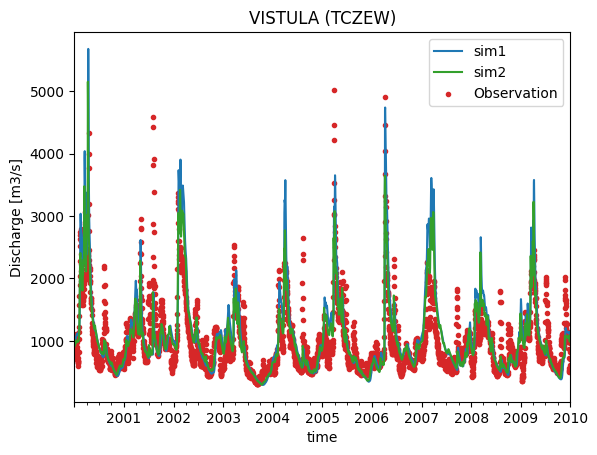

In [6]:
cmp.plot.timeseries();

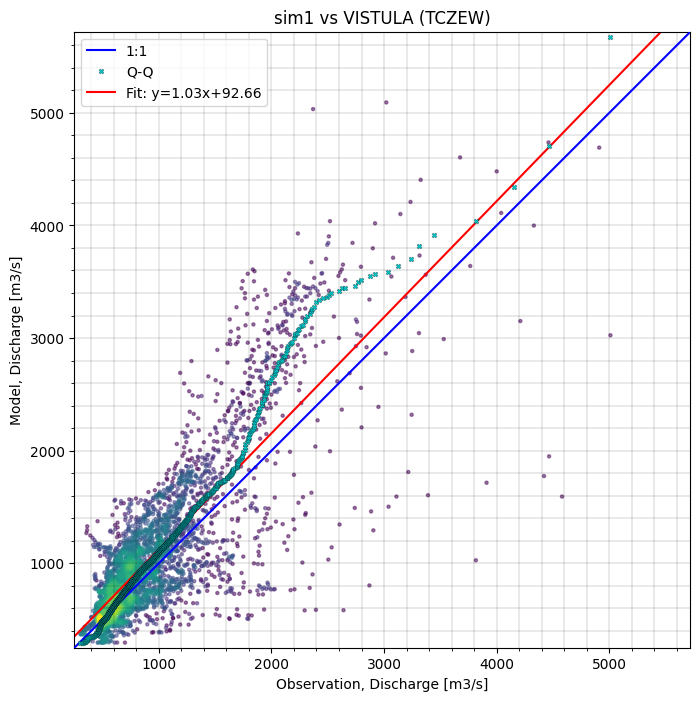

In [7]:
cmp.sel(model="sim1").plot.scatter();

### Summary statistics

In [8]:
# set default metrics
ms.options.metrics.list = ["kge", "cc"]

In [9]:
cmp.skill().round(3)

,,n,kge,cc
model,observation,,,
sim1,VISTULA (TCZEW),3653,0.617,0.794
sim2,VISTULA (TCZEW),3653,0.809,0.829


### Statistics aggregated by month

In [10]:
cmp.data["month"] = cmp.time.to_series().dt.month

In [11]:
cmp.skill(by=["model","month"]) #["kge"].plot.bar();

observation    n       kge        cc
model month                                          
sim1  1      VISTULA (TCZEW)  310  0.385138  0.440905
      2      VISTULA (TCZEW)  283  0.578280  0.803975
      3      VISTULA (TCZEW)  310  0.454622  0.730561
      4      VISTULA (TCZEW)  300  0.509017  0.834517
      5      VISTULA (TCZEW)  310  0.575944  0.697614
      6      VISTULA (TCZEW)  300  0.344820  0.493330
      7      VISTULA (TCZEW)  310  0.052140  0.298390
      8      VISTULA (TCZEW)  310  0.219232  0.667376
      9      VISTULA (TCZEW)  300  0.376622  0.552289
      10     VISTULA (TCZEW)  310  0.626824  0.717061
      11     VISTULA (TCZEW)  300  0.643888  0.741710
      12     VISTULA (TCZEW)  310  0.288263  0.452674
sim2  1      VISTULA (TCZEW)  310  0.580579  0.622109
      2      VISTULA (TCZEW)  283  0.844779  0.887547
      3      VISTULA (TCZEW)  310  0.669936  0.767161
      4      VISTULA (TCZEW)  300  0.764530  0.809858
      5      VISTULA (TCZEW)  310  0.487875  0.655435
      6      VISTULA (TCZEW)  300  0.496136  0.695364
      7      VISTULA (TCZEW)  310  0.235510  0.540092
      8      VISTULA (TCZEW)  310  0.269188  0.773781
      9      VISTULA (TCZEW)  300  0.526274  0.741995
      10     VISTULA (TCZEW)  310  0.719504  0.863399
      11     VISTULA (TCZEW)  300  0.721616  0.840079
      12     VISTULA (TCZEW)  310  0.506460  0.560932

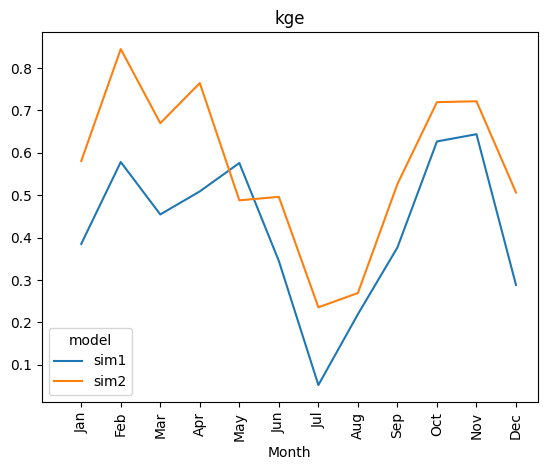

In [12]:
cmp.skill(by=["model","month"])["kge"].plot.line()
plt.xlabel("Month")
plt.xticks(np.arange(1,13), ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]);

## Compare multiple observations with two model results

In [13]:
# loop through all stations in df and create a Comparer for each
cmps = []
for id in df.index:
   try:
      cmps.append(get_comparer(df, ["sim1","sim2"], id))
   except ValueError as e:
      print("Failed to create comparer for station", id, ":", e)
cc = ms.ComparerCollection(cmps)
cc   

Failed to create comparer for station 6458500 : No data left after trimming to 2000-01-01 23:59:59 - 2010-01-01 00:00:01


<ComparerCollection>
Comparer: VISTULA (TCZEW)
Comparer: PILICA (PRZEDBORZ)
Comparer: WIEPRZ (LUBARTOW)
Comparer: WIEPRZ (KRASNYSTAW)
Comparer: KAMIENNA (KUNOW)
Comparer: VISTULA (SANDOMIERZ)
Comparer: VISTULA (SZCZUCIN)
Comparer: DUNAJEC (NOWY SACZ)
Comparer: POPRAD (CHMELNICA)
Comparer: WISLOK (TRYNCZA)
Comparer: PISA (PTAKI)
Comparer: NAREW (SURAZ)
Comparer: LIWIEC (LOCHOW)
Comparer: KRZNA (MALOWA GORA)

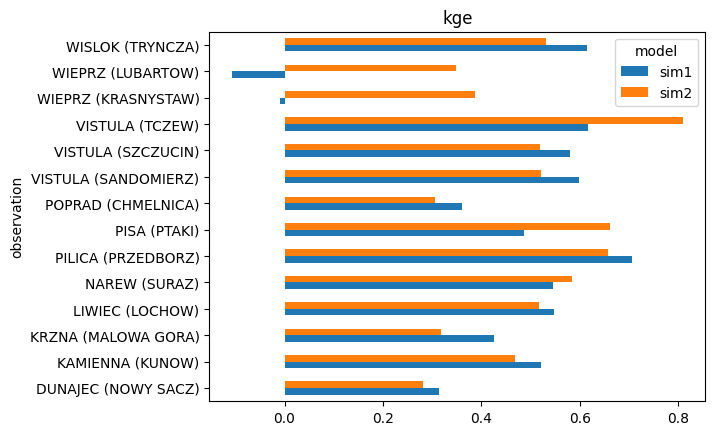

In [17]:
cc.skill(by=["model","observation"], metrics="kge")["kge"].plot.barh();

In [18]:
# Average skill over all stations, weighted by sqrt(area)
area = df.set_index("Station").loc[cc.obs_names].Area
cc.mean_skill(weights=np.sqrt(area)).round(3)

,n,kge,cc
model,,,
sim1,51142,0.430,0.649
sim2,51142,0.456,0.649
